In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import itertools
import scipy.stats

import statsmodels
from statannotations.Annotator import Annotator

/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/trc891/.conda/envs/cfn_final/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [2]:
def plot_gene_scores(adata, score_key, cell_type_key='cell_type_annot', hue='Class', min_cells=10,
                     min_subj=3,
                     comparisons_correction=None
                    ):
    #assumes adata.X includes all genes and is log1p(cpm) transformed
    df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()
    df = df[df[score_key]['count'] >= min_cells]
    df.columns = ['_'.join(x).rstrip('_') for x in df.columns.to_flat_index()]
    
    # drop cell types that don't have min_subj in each class
    for ct in df[cell_type_key].unique():
        if (len(df[(df[cell_type_key] == ct) & (df[hue] == 'CF')]) < min_subj) | (len(df[(df[cell_type_key] == ct) & (df[hue] == 'NC')]) < min_subj):
            print(f"dropping {ct} for < min_subj in one of (CF, HV) classes")
            df = df[df[cell_type_key] != ct]
            
    df[cell_type_key] = df[cell_type_key].cat.remove_unused_categories()
            
    pairs = [((ct, 'CF'), (ct, 'NC')) for ct in df[cell_type_key].unique()]

    ax = sns.stripplot(data=df, x=cell_type_key, y=score_key+'_mean', hue=hue, dodge=True,
                       edgecolor='k', linewidth=1
                      )
    sns.boxplot(data=df, x=cell_type_key, y=score_key+'_mean', hue=hue)
    plt.xticks(rotation=90)

    annot = Annotator(ax, pairs, data=df, x=cell_type_key, y=score_key+'_mean', hue=hue)
    annot.configure(test='Mann-Whitney', comparisons_correction=comparisons_correction,
                    correction_format="replace", verbose=2)
    annot.apply_test()
    annot.annotate()
    
    return ax

In [3]:
DATA_DIR = '../../data/10paper_figures/sc_files'
OUTPUT_DIR = '../../data/10paper_figures/fig6'

ds = sc.read_h5ad(f'{DATA_DIR}/00scvi_2025_02_24_v1.h5ad')

In [4]:
chaperome_gset_load = pd.read_csv('../../data/10paper_figures/BREHME_TABLE S2A.tsv',
                                  sep='\t')

chaperome_gset = chaperome_gset_load['Symbol'].to_list()

In [5]:
chaperome_gset_load

,Entrez-ID,Uniprot,Symbol,InterPro-domain,InterPro-match-string,Family (Interpro-match),Type,ATP-dependence,Functional category,Sub1-category,Sub2-category,Sub3-category,Compartment (literature/predicted),Brief description/Uniprot gene name,Description (Entrez Gene),Worm Ortholog ENSEMBL Gene ID,Worm Ortholog Gene Symbol,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,811,CALR_HUMAN,CALR,IPR018124; IPR009169; IPR008985; IPR001580; IP...,-,-,CHAP,N,ER,Calnexins,NaN,NaN,"ER, Cytoplasm,membrane rafts,Golgi apparatus,P...",Calreticulin,Calreticulin is a multifunctional protein that...,Y38A10A.5,crt-1,NaN,NaN,NaN
1,821,CALX_HUMAN,CANX,IPR008985; IPR013320; IPR018124; IPR001580; IP...,-,-,CHAP,N,ER,Calnexins,NaN,NaN,"ER, Cytoplasm,membrane rafts,Golgi apparatus,P...",Calnexin,This gene encodes a member of the calnexin fam...,ZK632.6,cnx-1,NaN,NaN,NaN
2,1047,CLGN_HUMAN,CLGN,IPR009033; IPR013320; IPR001580; IPR008985; IP...,-,-,CHAP,N,ER,Calnexins,NaN,NaN,"ER, Cytoplasm,membrane rafts,Golgi apparatus,P...",Calmegin,Calmegin is a testis-specific endoplasmic reti...,ZK632.6,cnx-1,NaN,NaN,NaN
3,7415,Q96IF9_HUMAN; TERA_HUMAN,VCP,IPR003959; IPR003960; IPR015415; IPR003593; IP...,-,-,CHAP,YES,ER,Hsp100/AAA+,UPR/ERAD,NaN,Cytoplasm,Transitional endoplasmic reticulum ATPase,The protein encoded by this gene is a member o...,C06A1.1; C41C4.8,cdc-48.1; cdc-48.2,NaN,NaN,NaN
4,1861,TOR1A_HUMAN; B3KPA1_HUMAN,TOR1A,IPR010448; IPR017378,Torsin_IPR010448,-,CHAP,YES,ER,Hsp100/AAA+,NaN,NaN,ER,"torsin family 1, member A (torsin A)",The protein encoded by this gene is a member o...,Y37A1B.12; C18E9.11; Y37A1B.13,tor-1; ooc-5; tor-2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,10811,NOXA1_HUMAN,NOXA1,IPR000270; IPR019734; IPR000108; IPR001452; IP...,"TPR_IPR013105, TPR_IPR013026, IPR019734",TPR,CO-CHAP,N,TPR,Co-chaperones,Co-Hsp70/Hsp90,NaN,"Cytoplasm, NADPH oxidase complex",NADPH oxidase activator 1,NADPH oxidases (NOXs) catalyze the transfer of...,-,-,NaN,NaN,NaN
328,148014,TTC9B_HUMAN,TTC9B,IPR019734; IPR013105; IPR013026; IPR011990,"TPR_IPR013105, TPR_IPR013026, IPR019734",TPR,CO-CHAP,N,TPR,Co-chaperones,Co-Hsp70/Hsp90,NaN,-,Tetratricopeptide repeat protein 9B,-,-,-,NaN,NaN,NaN
329,283237,TTC9C_HUMAN,TTC9C,IPR013105; IPR013026; IPR011990; IPR023566; IP...,"TPR_IPR013105, TPR_IPR013026, IPR019734",TPR,CO-CHAP,N,TPR,Co-chaperones,Co-Hsp70/Hsp90,NaN,-,Tetratricopeptide repeat protein 9C,-,-,-,NaN,NaN,NaN
330,23331,TTC28_HUMAN,TTC28,IPR011990; IPR024983; IPR013105; IPR019734; IP...,"TPR_IPR013105, TPR_IPR013026, TPR_IPR001440, I...",TPR,CO-CHAP,N,TPR,Co-chaperones,Co-Hsp70/Hsp90,NaN,-,Tetratricopeptide repeat protein 28,-,F32A6.4; Y22D7AL.9,ags-3; Y22D7AL.9,NaN,NaN,NaN


In [6]:
HALLMARK_INTERFERON_ALPHA_RESPONSE = pd.read_csv('../../data/10paper_figures/HALLMARK_INTERFERON_ALPHA_RESPONSE.v2024.1.Hs.grp',
                                                skiprows=[1])['HALLMARK_INTERFERON_ALPHA_RESPONSE'].to_list()

In [7]:
ds_score_normed = ds.copy()
ds_score_normed = ds_score_normed.raw.to_adata()

ds_score_normed.layers["counts"] = ds_score_normed.X.copy()

sc.pp.normalize_per_cell(ds_score_normed, counts_per_cell_after=1e6)
sc.pp.log1p(ds_score_normed)

In [8]:
ds_score_normed

AnnData object with n_obs × n_vars = 89601 × 22039
    obs: 'orig.ident', 'Doublet score', 'Library ID', 'Chemistry', 'GEX library Index', 'Step 1 date YYYY/MM/DD', 'Project', 'Class', 'Sample', 'Cell viabiliy', 'Age', 'Sex', 'Race', 'OnModulator', 'Modulator', 'Include', 'Comments', 'n_genes', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_mod', 'leiden_unmerged', 'leiden_final', 'cell_type_annot', 'cell_type_annot_unmerged', 'leiden_orig', 'n_counts'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'n_cells-14', 'gene_ids

In [9]:
sc.tl.score_genes(ds_score_normed, chaperome_gset, score_name='chaperome_score', random_state=2,
                  copy=False, use_raw=False, ctrl_size=len(chaperome_gset))

       'CCT8L1P', 'CCT8L2', 'HSPA7', 'HSPA12B', 'AHSA2', 'PPIAL4A', 'PPIAL4G',
       'SDCCAG10', 'FKBP9L', 'AIPL1', 'HSP90AA2', 'C19orf2', 'HSPB2', 'HSPB6',
       'CRYAA', 'HSPB3', 'LEPREL1', 'TOMM70A', 'FAM10A5', 'DYX1C1', 'UNC45B',
       'TTC15', 'NARG1L', 'NFKBIL2', 'TTC18', 'UTX', 'IFIT1L', 'NARG1'],
      dtype='object')


In [10]:
len(chaperome_gset)

332

In [11]:
len(set(chaperome_gset).intersection(set(ds_score_normed.var_names)))

297

<Axes: title={'center': 'chaperome_score'}, xlabel='UMAP1', ylabel='UMAP2'>

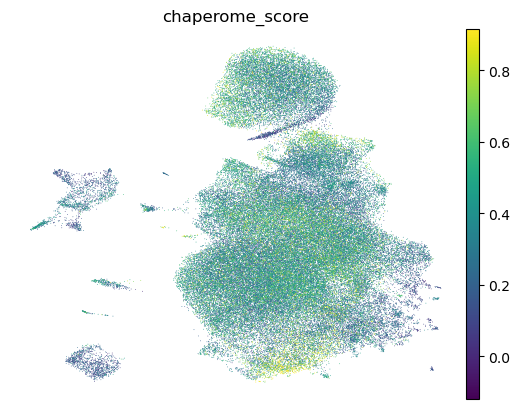

In [12]:
sc.pl.umap(
    ds_score_normed,
    color=['chaperome_score'],
    vmax='p99',
    frameon=False,
    show=False
)

#plt.savefig(f'{OUTPUT_DIR}/fig6a.png', dpi=300)

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.515e-02 U_stat=3.000e+00
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.112e-02 U_stat=1.100e+01
Mul

<Axes: xlabel='cell_type_annot', ylabel='chaperome_score_mean'>

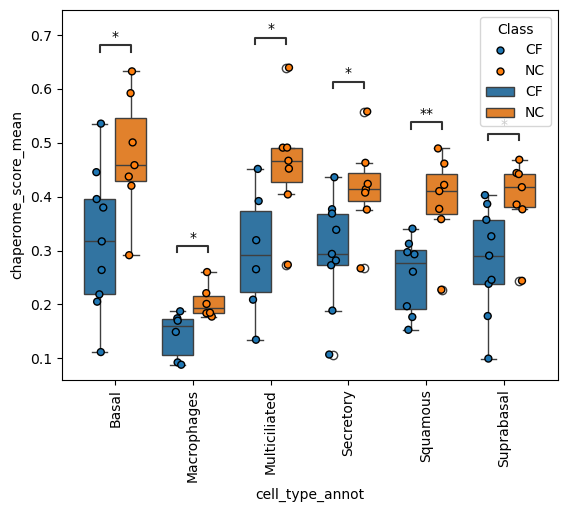

In [13]:
plot_gene_scores(ds_score_normed, 'chaperome_score', comparisons_correction='BH')

In [14]:
sc.tl.score_genes(ds_score_normed, HALLMARK_INTERFERON_ALPHA_RESPONSE, score_name='HM_IFNA_RESPONSE',
                  copy=False, use_raw=False, ctrl_size=len(HALLMARK_INTERFERON_ALPHA_RESPONSE))

<Axes: title={'center': 'HM_IFNA_RESPONSE'}, xlabel='UMAP1', ylabel='UMAP2'>

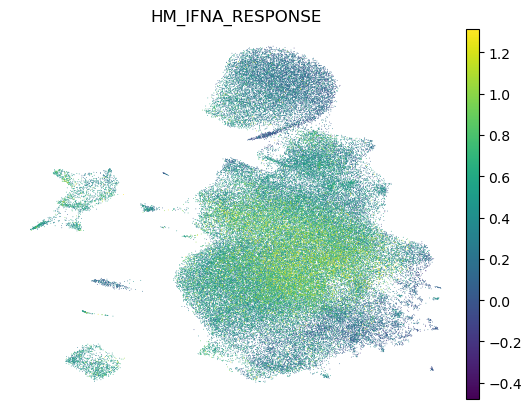

In [15]:
sc.pl.umap(
    ds_score_normed,
    color=['HM_IFNA_RESPONSE'],
    vmax='p99',
    frameon=False,
    show=False
)

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.095e-01 U_stat=1.100e+01
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.490e-02 U_stat=1.300e+01
Mul

<Axes: xlabel='cell_type_annot', ylabel='HM_IFNA_RESPONSE_mean'>

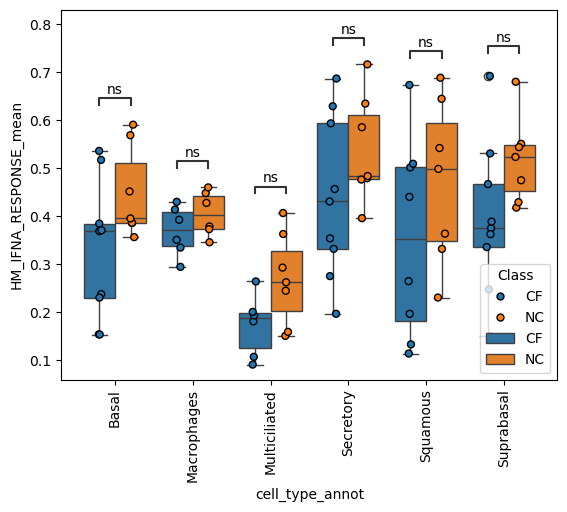

In [16]:
plot_gene_scores(ds_score_normed, 'HM_IFNA_RESPONSE', comparisons_correction='BH')

## Specific Genes from Chaperome?

In [17]:
celltypes_of_interest = ['Macrophages',
                         'Basal',
                         'Multiciliated',
                         'Secretory',
                         'Squamous',
                         'Suprabasal'
                        ]

### Use the Chaperome Database

In [18]:
calnexins = chaperome_gset_load[chaperome_gset_load['Sub1-category'] == 'Calnexins']['Symbol'].to_list()
hsp70s = chaperome_gset_load[chaperome_gset_load['Sub1-category'] == 'HSP70s']['Symbol'].to_list()
hsp90s = chaperome_gset_load[chaperome_gset_load['Sub1-category'] == 'HSP90s']['Symbol'].to_list()
dnajs = chaperome_gset_load[chaperome_gset_load['Sub3-category'] == 'DnaJ']['Symbol'].to_list()

In [19]:
sc.tl.score_genes(ds_score_normed, calnexins, score_name='calnexin_score', copy=False, use_raw=False)
sc.tl.score_genes(ds_score_normed, hsp70s, score_name='hsp70s_score', copy=False, use_raw=False)
sc.tl.score_genes(ds_score_normed, hsp90s, score_name='hsp90s_score', copy=False, use_raw=False)
sc.tl.score_genes(ds_score_normed, dnajs, score_name='dnajs_score', copy=False, use_raw=False)

In [20]:
hsp70s = [x for x in hsp70s if x not in ['HSPA7', 'HSPA12B']]
hsp90s = [x for x in hsp90s if x not in ['HSP90AA2']]
dnajs = [x for x in dnajs if x not in ['DNAJC5G', 'DNAJB3', 'DNAJB8']]

### Plot

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.113e-02 (ns) U_stat=5.000e+00
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.738e-01 U_stat=1.800e+0

<Axes: xlabel='cell_type_annot', ylabel='calnexin_score_mean'>

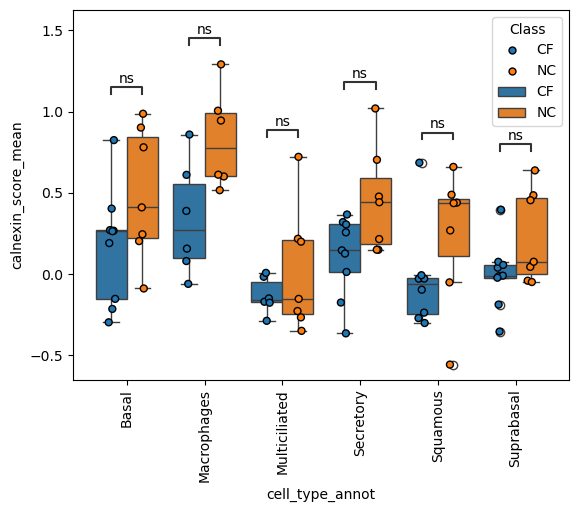

In [21]:
plot_gene_scores(ds_score_normed, 'calnexin_score', comparisons_correction='BH')

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.887e-01 U_stat=1.400e+01
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.105e-01 U_stat=1.900e+01
Mul

<Axes: xlabel='cell_type_annot', ylabel='hsp70s_score_mean'>

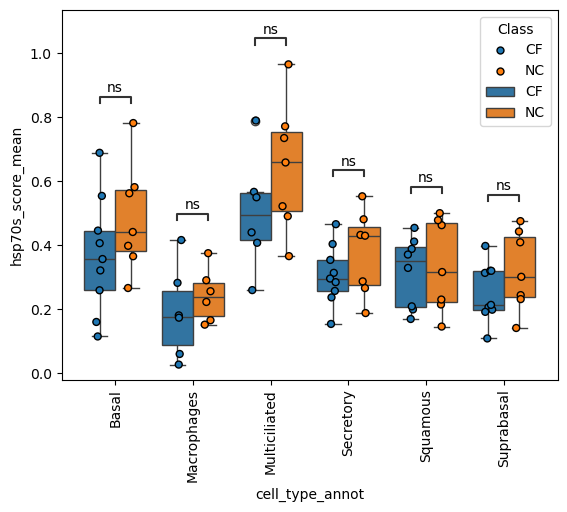

In [22]:
plot_gene_scores(ds_score_normed, 'hsp70s_score', comparisons_correction='BH')

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.848e-01 U_stat=1.300e+01
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.991e-01 U_stat=2.100e+01
Mul

<Axes: xlabel='cell_type_annot', ylabel='hsp90s_score_mean'>

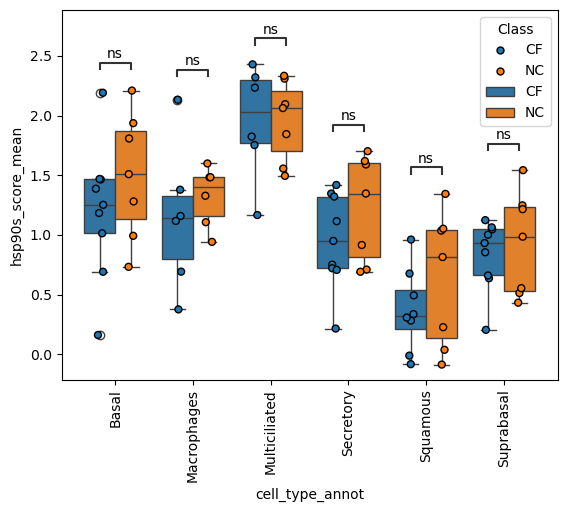

In [23]:
plot_gene_scores(ds_score_normed, 'hsp90s_score', comparisons_correction='BH')

/tmp/ipykernel_3749563/1878537988.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Sample', hue, cell_type_key]).agg({score_key: ['mean', 'count']}).reset_index()


dropping CD8+ T-cells for < min_subj in one of (CF, HV) classes
dropping Monocytes for < min_subj in one of (CF, HV) classes
dropping DC2 for < min_subj in one of (CF, HV) classes
dropping Ionocytes for < min_subj in one of (CF, HV) classes
dropping B-cells for < min_subj in one of (CF, HV) classes
dropping CD4+ T-cells for < min_subj in one of (CF, HV) classes
dropping Mast for < min_subj in one of (CF, HV) classes
dropping Stromal for < min_subj in one of (CF, HV) classes
dropping pDCs for < min_subj in one of (CF, HV) classes
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Macrophages_CF vs. Macrophages_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.182e-01 U_stat=1.600e+01
Basal_CF vs. Basal_NC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.867e-03 U_stat=7.000e+00
Mul

<Axes: xlabel='cell_type_annot', ylabel='dnajs_score_mean'>

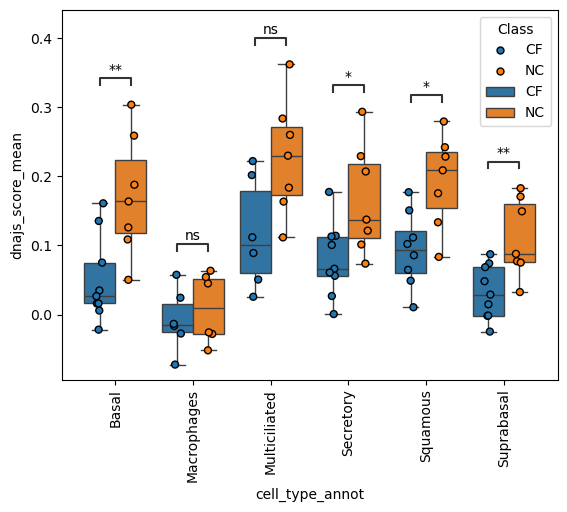

In [24]:
plot_gene_scores(ds_score_normed, 'dnajs_score', comparisons_correction='BH')

Macrophages


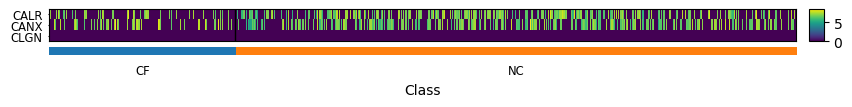

Basal


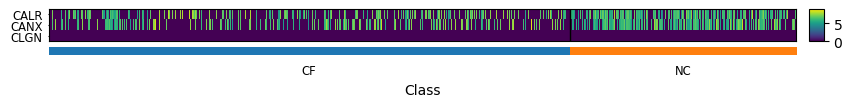

Multiciliated


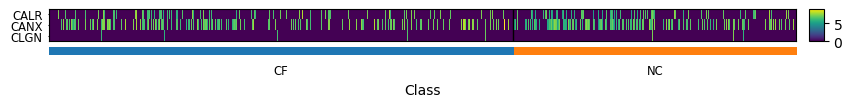

Secretory


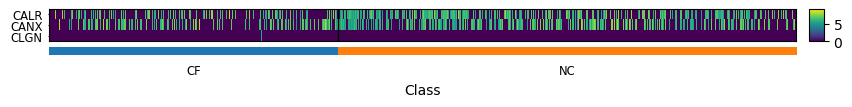

Squamous


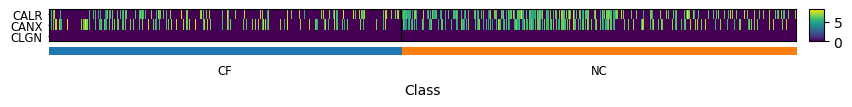

Suprabasal


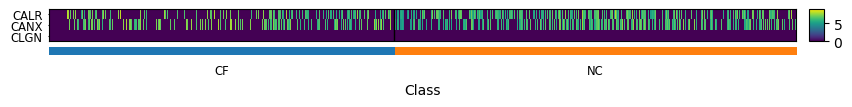

In [25]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  calnexins,
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

Macrophages


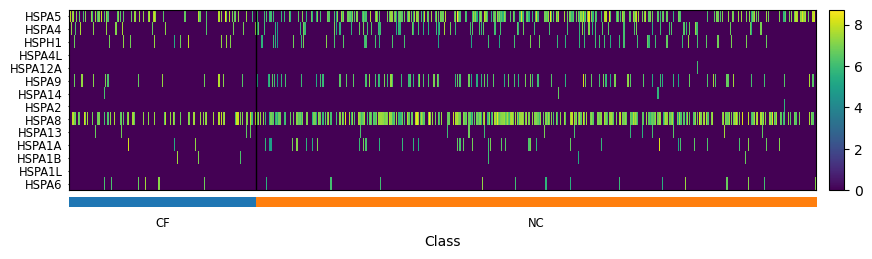

Basal


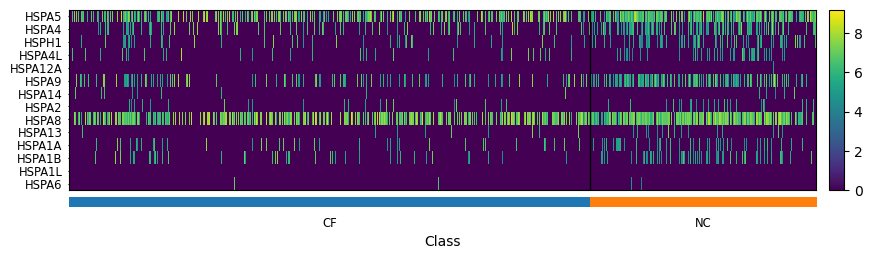

Multiciliated


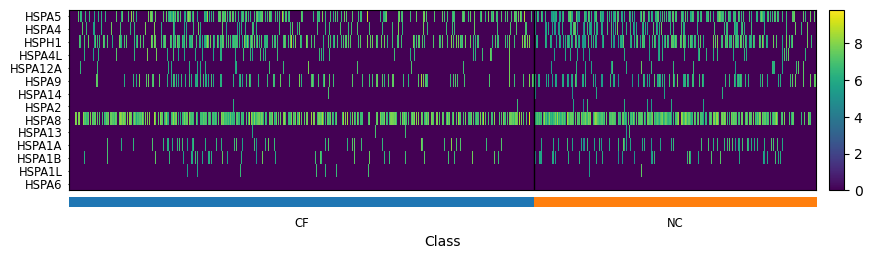

Secretory


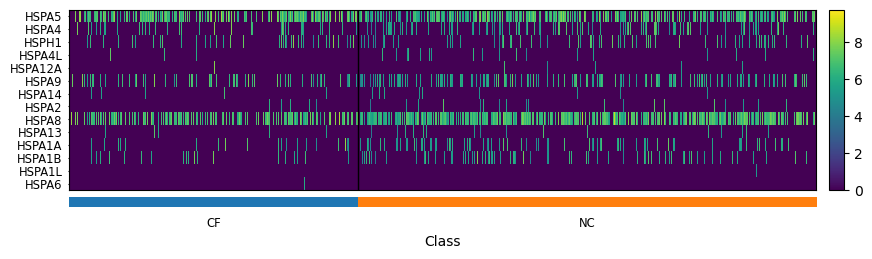

Squamous


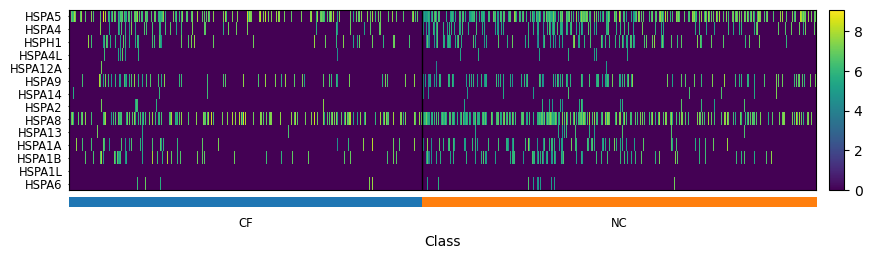

Suprabasal


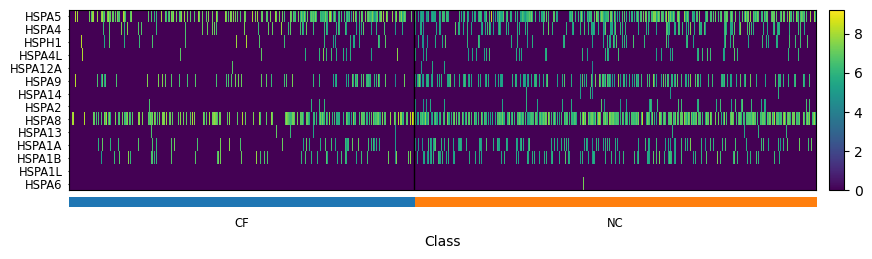

In [26]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  hsp70s,
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

Macrophages


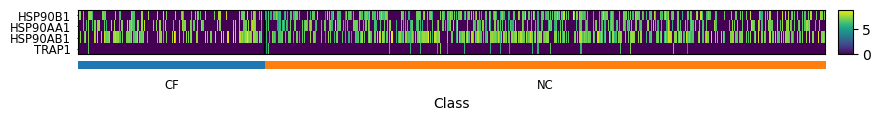

Basal


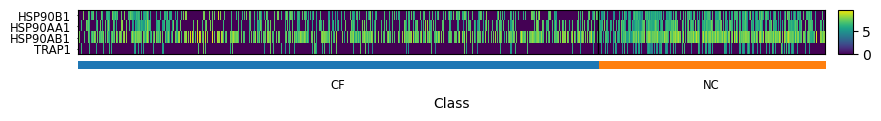

Multiciliated


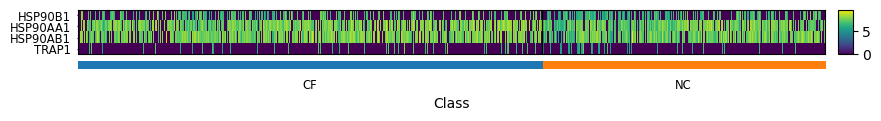

Secretory


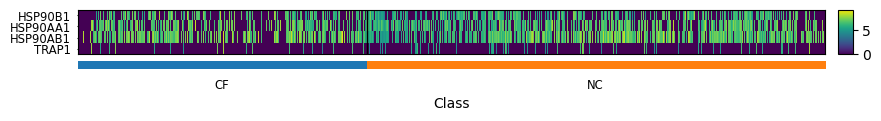

Squamous


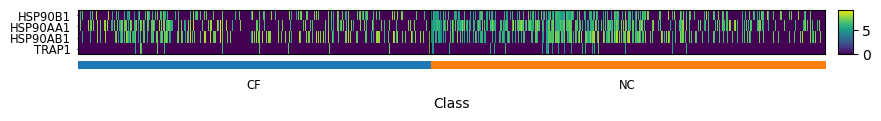

Suprabasal


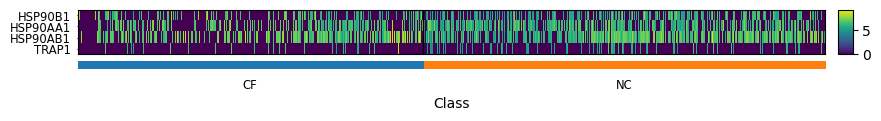

In [27]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  hsp90s,
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

Macrophages


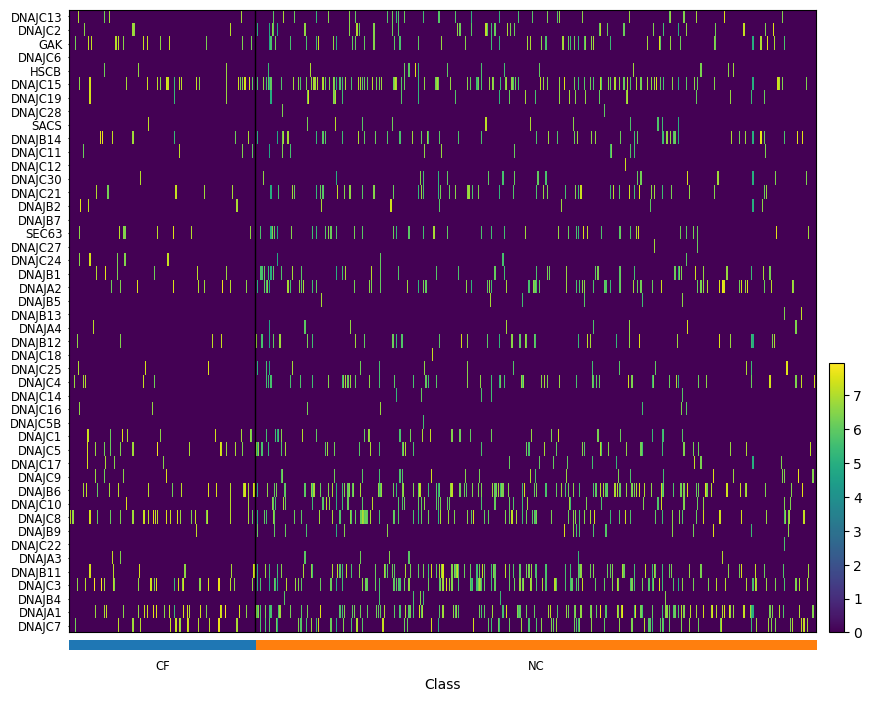

Basal


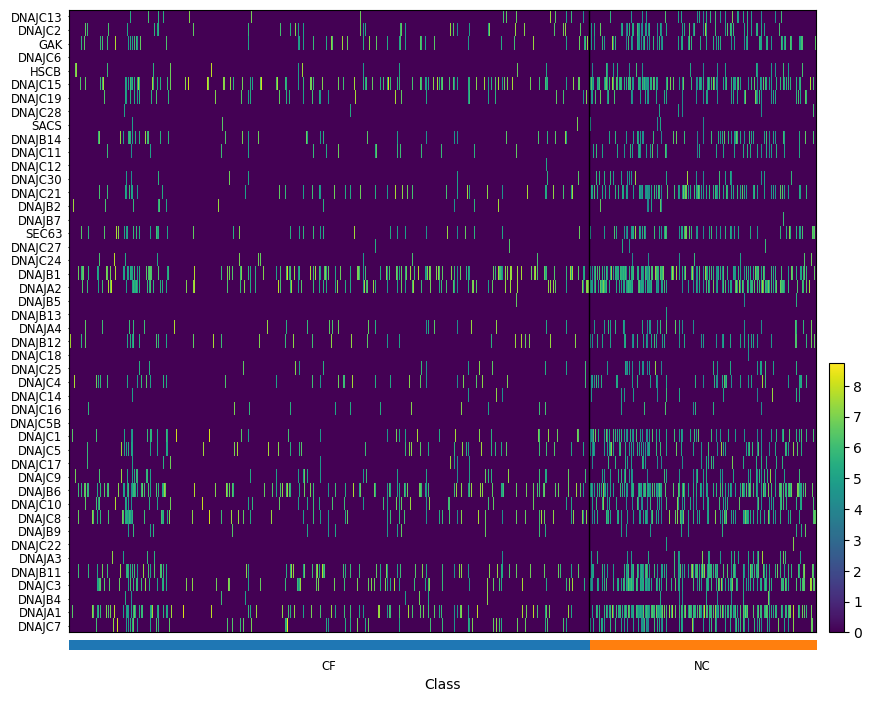

Multiciliated


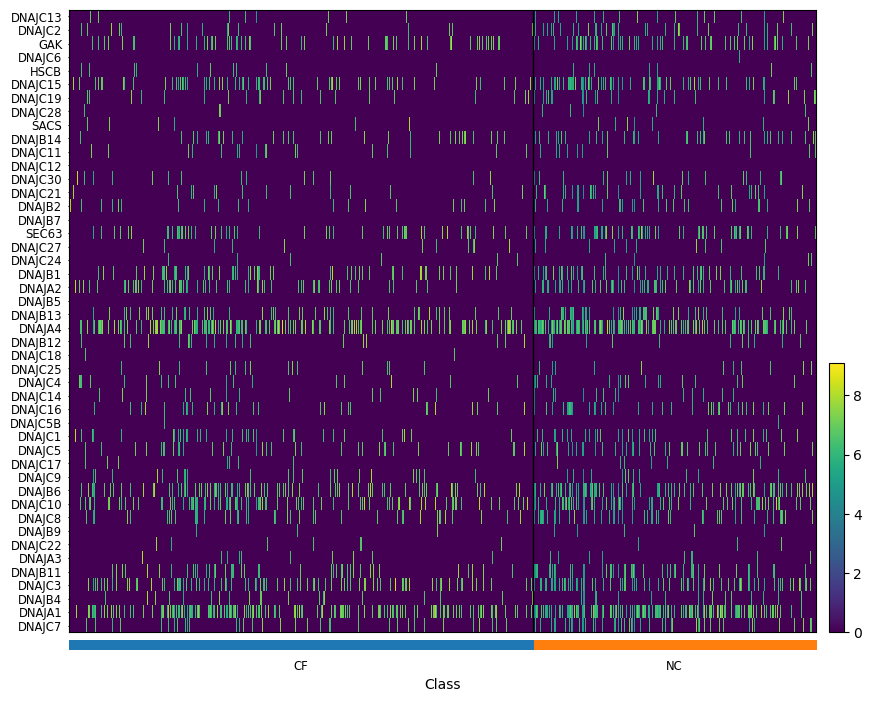

Secretory


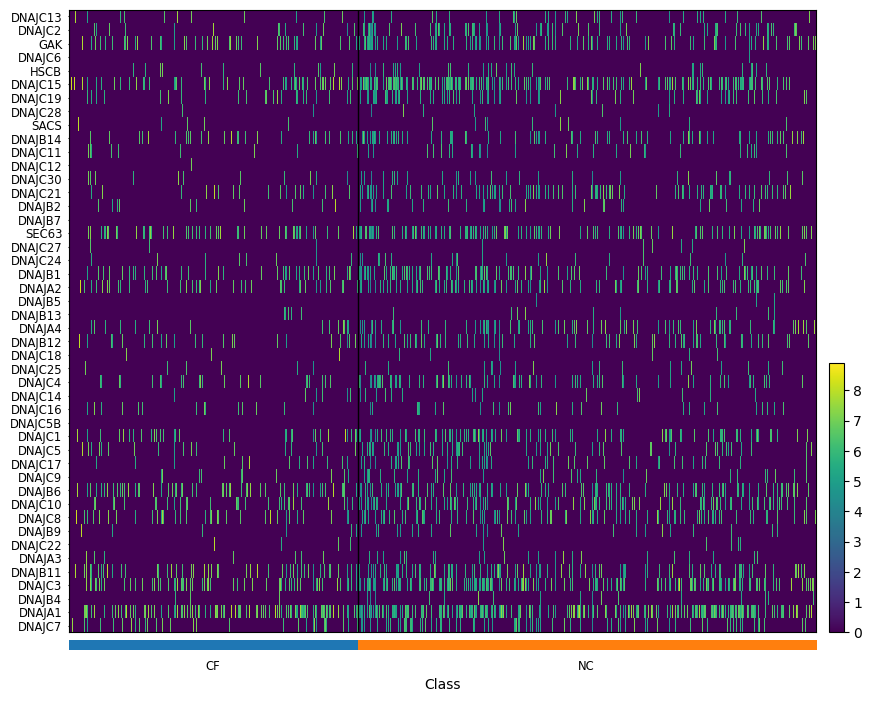

Squamous


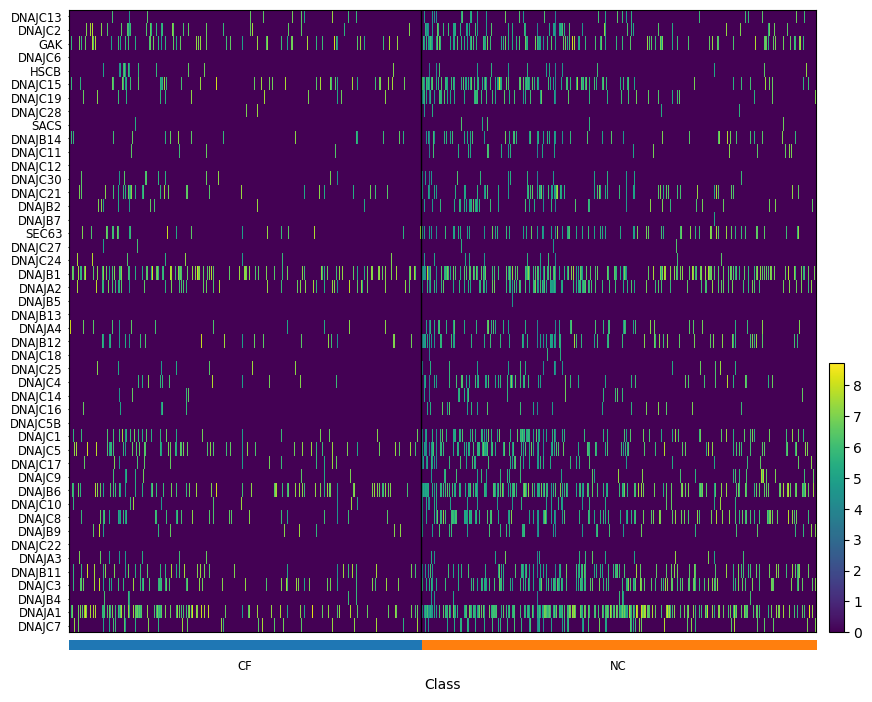

Suprabasal


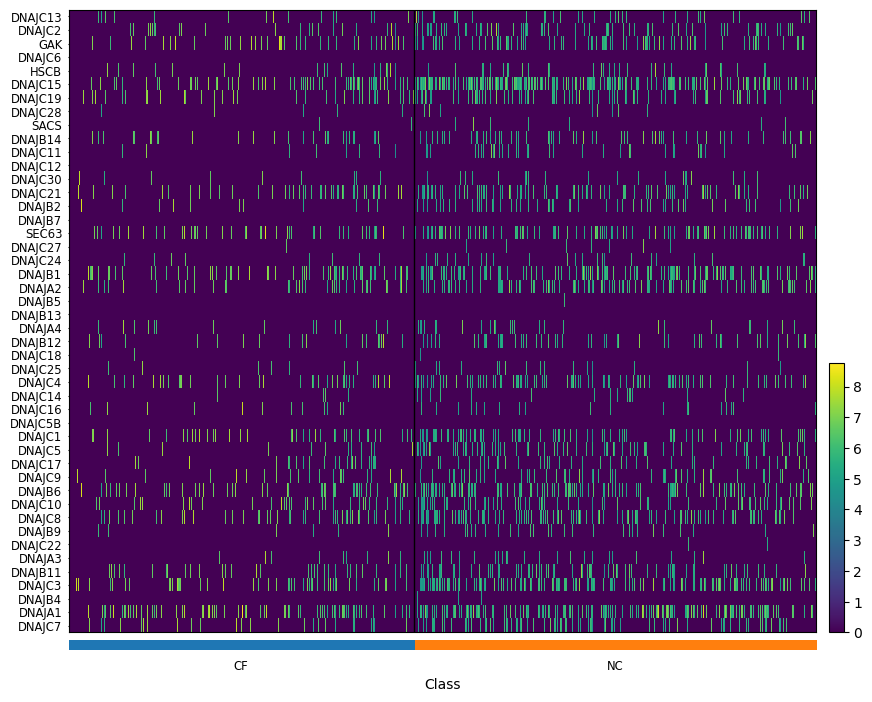

In [28]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  dnajs,
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

Macrophages


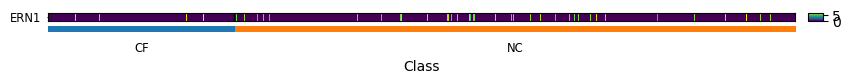

Basal


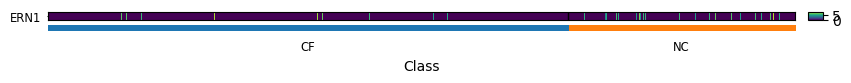

Multiciliated


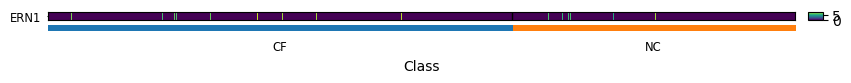

Secretory


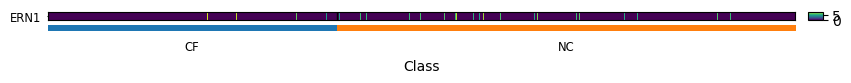

Squamous


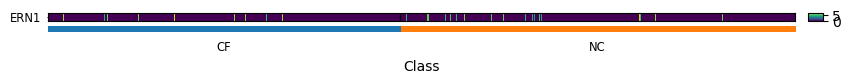

Suprabasal


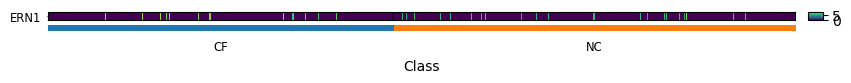

In [29]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  ['ERN1'],
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

Macrophages


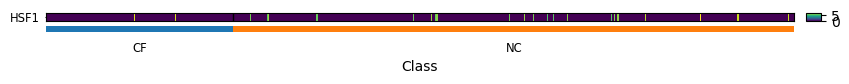

Basal


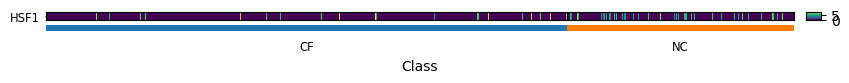

Multiciliated


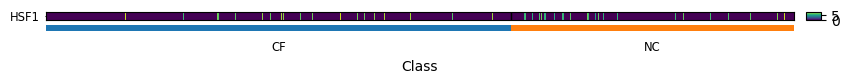

Secretory


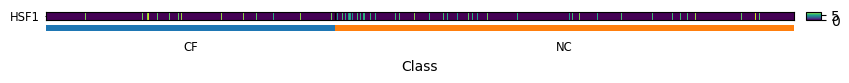

Squamous


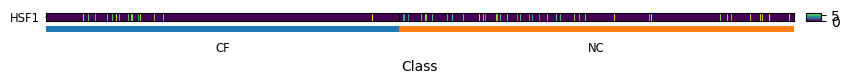

Suprabasal


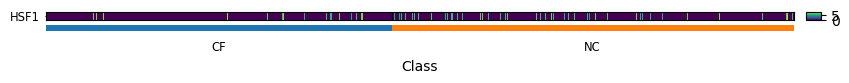

In [30]:
for ct in celltypes_of_interest:
    print(ct)
    sc.pl.heatmap(ds_score_normed[ds_score_normed.obs['cell_type_annot'] == ct].copy(),
                  ['HSF1'],
                  groupby='Class',
                  swap_axes=True
                 )
    
plt.show()

In [54]:
gene_symbol = 'CFTR'
gene_df = pd.DataFrame({'log1p(norm cts)': ds_score_normed[:, 'CFTR'].X.toarray().squeeze(),
                        'Class': ds_score_normed[:, 'CFTR'].obs['Class']})

In [55]:
gene_df

,log1p(norm cts),Class
SC178_AAACCTGAGATCCCAT-1-0,0.0,CF
SC178_AAACCTGAGATTACCC-1-0,0.0,CF
SC178_AAACCTGAGCTAACTC-1-0,0.0,CF
SC178_AAACCTGAGTTAACGA-1-0,0.0,CF
SC178_AAACCTGGTAAAGGAG-1-0,0.0,CF
...,...,...
SC185_TTTGTCAAGATATGCA-1-17,0.0,NC
SC185_TTTGTCAGTAAGTTCC-1-17,0.0,NC
SC185_TTTGTCAGTGTATGGG-1-17,0.0,NC
SC185_TTTGTCAGTTTCGCTC-1-17,0.0,NC


<Axes: xlabel='log1p(norm cts)', ylabel='Count'>

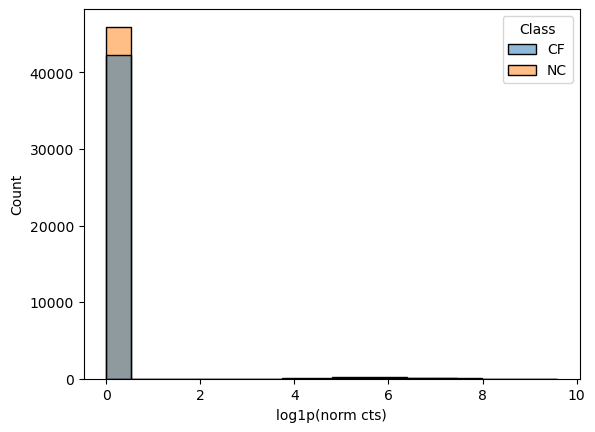

In [58]:
sns.histplot(gene_df, x='log1p(norm cts)', hue='Class')